# Initialization

#### Installing prerequisites and Importing libraries


we make sure the libraries and package are all installed.

In [51]:
# !pip install lazypredict
# !pip install fastparquet
# !pip install catboost
# !pip install category_encoders
# !pip install dask[dataframe]
# !pip install statsmodels

In [52]:
import pandas as pd
import numpy as np
# import warnings

# from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.ensemble import BaggingClassifier
# from sklearn.tree import DecisionTreeClassifier

# from scipy.stats import zscore

# import category_encoders as ce
# from catboost import CatBoostRegressor
# from catboost import Pool

import matplotlib.pyplot as plt
import seaborn as sns
from lazypredict.Supervised import LazyClassifier

from statsmodels.stats.outliers_influence import variance_inflation_factor

I've imported the dataset using kaggle package:

In [53]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("dhoogla/nftoniotv2")

# print("Path to dataset files:", path)

## Reading the Dataset

Using pandas to read the paraquet file:

In [54]:
df = pd.read_parquet("NF-ToN-IoT-V2.parquet", engine='fastparquet')

df

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack
0,49235,4444,6,0.00,155392,202,34552,149,24,24,...,45555,4805,0,0,0,0,0,0,1,ransomware
1,49228,1880,6,0.00,1600,40,35741,65,24,16,...,16425,237,0,0,0,0,0,0,0,Benign
2,0,0,1,0.00,212,2,0,0,0,0,...,0,0,771,3,0,0,0,0,0,Benign
3,65317,1900,17,0.00,165,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Benign
4,60766,15600,17,0.00,63,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13135876,49200,4444,6,0.00,152960,210,36392,163,24,24,...,16425,2385,0,0,0,0,0,0,1,ransomware
13135877,1880,49178,6,0.00,31067,49,1160,29,24,24,...,237,16425,0,0,0,0,0,0,0,Benign
13135878,43,37796,6,170.00,4275,5,296,5,25,25,...,453,1024,19200,75,0,0,0,0,0,Benign
13135879,443,49198,6,91.18,191,4,151,3,25,25,...,64240,63846,0,0,0,0,0,0,0,Benign


In [55]:
print(df.columns)

Index(['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'IN_BYTES',
       'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS', 'TCP_FLAGS', 'CLIENT_TCP_FLAGS',
       'SERVER_TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'DURATION_IN',
       'DURATION_OUT', 'MIN_TTL', 'MAX_TTL', 'LONGEST_FLOW_PKT',
       'SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN', 'MAX_IP_PKT_LEN',
       'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES',
       'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS',
       'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS',
       'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT',
       'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES',
       'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES',
       'NUM_PKTS_1024_TO_1514_BYTES', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT',
       'ICMP_TYPE', 'ICMP_IPV4_TYPE', 'DNS_QUERY_ID', 'DNS_QUERY_TYPE',
       'DNS_TTL_ANSWER', 'FTP_COMMAND_RET_CODE', 'Label', 'Attack'],
      dtype='object')


Then we check the cardinality of each feature in the complete dataset. We're trying to find how many unique values each feature has to choose the best Standardization/Normalization/Encoding method for each feature.

In [56]:
# List of features to check
features = ['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'IN_BYTES',
       'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS', 'TCP_FLAGS', 'CLIENT_TCP_FLAGS',
       'SERVER_TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'DURATION_IN',
       'DURATION_OUT', 'MIN_TTL', 'MAX_TTL', 'LONGEST_FLOW_PKT',
       'SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN', 'MAX_IP_PKT_LEN',
       'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES',
       'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS',
       'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS',
       'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT',
       'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES',
       'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES',
       'NUM_PKTS_1024_TO_1514_BYTES', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT',
       'ICMP_TYPE', 'ICMP_IPV4_TYPE', 'DNS_QUERY_ID', 'DNS_QUERY_TYPE',
       'DNS_TTL_ANSWER', 'FTP_COMMAND_RET_CODE', 'Label', 'Attack']

# Compute cardinality for each feature
cardinality = df[features].nunique()
cardinality_sorted = cardinality.sort_values()

# Display the sorted cardinality
print(cardinality_sorted)


Label                               2
PROTOCOL                            6
Attack                             10
DNS_QUERY_TYPE                     12
FTP_COMMAND_RET_CODE               17
SERVER_TCP_FLAGS                   31
CLIENT_TCP_FLAGS                   33
TCP_FLAGS                          34
MAX_TTL                           109
MIN_IP_PKT_LEN                    121
MIN_TTL                           142
L7_PROTO                          213
RETRANSMITTED_IN_PKTS             245
ICMP_IPV4_TYPE                    256
RETRANSMITTED_OUT_PKTS            300
ICMP_TYPE                         417
SHORTEST_FLOW_PKT                 709
NUM_PKTS_512_TO_1024_BYTES        796
TCP_WIN_MAX_OUT                   867
NUM_PKTS_256_TO_512_BYTES         912
NUM_PKTS_1024_TO_1514_BYTES      1133
DURATION_OUT                     1425
DURATION_IN                      1779
FLOW_DURATION_MILLISECONDS       1799
OUT_PKTS                         1872
MAX_IP_PKT_LEN                   1932
LONGEST_FLOW

Then we make two sample subsets of the complete satset.
The first one is for training the models and it randomly chooses 1% of the samples. (131,359 samples)
The second sample dataframe is for comparing different methods using lazy predict. Since training and evaluating the dataset using lazypredict makes the program crash using the main sample, I've made a smaller sample subset just for lazypredict. This sample randomly chooses 0.08% of the samples in the complete dataset. (10,509 samples)

In [57]:
df_sampled = df.sample(frac=0.1, random_state=42)
lp_sampled = df.sample(frac=0.08, random_state=42)

# Check the size of the sampled dataset
print("Main Sampled Dataframe: ", df_sampled.shape)
print("Smaller Sampled Dataframe for Lazypredict: ", lp_sampled.shape)

Main Sampled Dataframe:  (1313588, 43)
Smaller Sampled Dataframe for Lazypredict:  (1050870, 43)


## Splitting the dataset to train and test

In [58]:
# Main sampled dataset
X_main = df_sampled.drop(['Attack', 'Label'], axis=1)  # Features
y_main = df_sampled['Attack']  # Target variable

# LazyPredict sampled dataset
X_lp = lp_sampled.drop(['Attack', 'Label'], axis=1)  # Features
y_lp = lp_sampled['Attack']  # Target variable

# Split the main sampled dataset (1%)
X_train_main, X_test_main, y_train_main, y_test_main = train_test_split(
    X_main, y_main, test_size=0.3, random_state=42
)

# Split the LazyPredict dataset (0.08%)
X_train_lp, X_test_lp, y_train_lp, y_test_lp = train_test_split(
    X_lp, y_lp, test_size=0.3, random_state=42
)

print("Main Dataset Train Shape: ", X_train_main.shape)
print("Main Dataset Test Shape: ", X_test_main.shape)
print("LazyPredict Dataset Train Shape: ", X_train_lp.shape)
print("LazyPredict Dataset Test Shape: ", X_test_lp.shape)

Main Dataset Train Shape:  (919511, 41)
Main Dataset Test Shape:  (394077, 41)
LazyPredict Dataset Train Shape:  (735609, 41)
LazyPredict Dataset Test Shape:  (315261, 41)


In [59]:
del df
# the main dataframe is very large and could possibly cause errors with the kernel.

# Preprocess

Based on the information on the dataset's page on kaggle site, this dataset has already cleaned and there are 0 records with missing values, and 0 duplicate records.

### Normalization and Standardization of Numerical Features

We continue by standardization and normalization. There are two methods:
Min-Max normalization and Z-score standardization.

We use the first one for for features with arbitrary value ranges or skewed distributions.
And the second method is used for normally distributed features or those with outliers.

Based on the features on this dataset, We use this two methods for these features:



1.   Min-Max Normalization
  *   IN_BYTES
  *   OUT_BYTES
  *   IN_PKTS
  *   OUT_PKTS
  *   FLOW_DURATION_MILLISECONDS
  *   DURATION_IN
  *   DURATION_OUT
  *   SRC_TO_DST_SECOND_BYTES
  *   DST_TO_SRC_SECOND_BYTES
  *   RETRANSMITTED_IN_BYTES
  *   RETRANSMITTED_OUT_BYTES
  *   RETRANSMITTED_IN_PKTS
  *   RETRANSMITTED_OUT_PKTS
  *   SRC_TO_DST_AVG_THROUGHPUT
  *   DST_TO_SRC_AVG_THROUGHPUT
  *   NUM_PKTS_UP_TO_128_BYTES
  *   NUM_PKTS_128_TO_256_BYTES
  *   NUM_PKTS_256_TO_512_BYTES
  *   NUM_PKTS_512_TO_1024_BYTES
  *   NUM_PKTS_1024_TO_1514_BYTES
  *   DNS_TTL_ANSWER



2.   Z-score Standardization
  *   MIN_TTL
  *   MAX_TTL
  *   LONGEST_FLOW_PKT
  *   SHORTEST_FLOW_PKT
  *   MIN_IP_PKT_LEN
  *   MAX_IP_PKT_LEN
  *   TCP_WIN_MAX_IN
  *   TCP_WIN_MAX_OUT


3.   Categorial Features (Unchanged)
  *   L4_SRC_PORT
  *   L4_DST_PORT
  *   PROTOCOL
  *   L7_PROTO
  *   TCP_FLAGS
  *   CLIENT_TCP_FLAGS
  *   SERVER_TCP_FLAGS
  *   ICMP_TYPE
  *   ICMP_IPV4_TYPE
  *   DNS_QUERY_ID
  *   DNS_QUERY_TYPE
  *   FTP_COMMAND_RET_CODE

In [60]:
features_to_normalize = [
    'IN_BYTES', 'OUT_BYTES', 'IN_PKTS',
    'OUT_PKTS', 'FLOW_DURATION_MILLISECONDS', 'DURATION_IN', 'DURATION_OUT',
    'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES',
    'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_OUT_BYTES',
    'RETRANSMITTED_IN_PKTS', 'RETRANSMITTED_OUT_PKTS',
    'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT',
    'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES',
    'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES',
    'NUM_PKTS_1024_TO_1514_BYTES', 'DNS_TTL_ANSWER'
]

features_to_standardize = [
    'MIN_TTL', 'MAX_TTL', 'LONGEST_FLOW_PKT', 'SHORTEST_FLOW_PKT',
    'MIN_IP_PKT_LEN', 'MAX_IP_PKT_LEN', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT'
]

categorial_featues = [
    'L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'TCP_FLAGS',
    'CLIENT_TCP_FLAGS', 'SERVER_TCP_FLAGS', 'ICMP_TYPE', 'ICMP_IPV4_TYPE',
    'DNS_QUERY_ID', 'DNS_QUERY_TYPE', 'FTP_COMMAND_RET_CODE'
]

The function below uses MinMaxScaler() and StandardScaler() from scikit-learn library to standardize and normalize numerical features and returns a copy of the giver dataframe.


In [61]:
def preprocess_data_train_test(train_data, test_data, normalize_features, standardize_features):
    """
    Preprocess the train and test data by applying Min-Max normalization and Z-score standardization.
    Args:
        train_data (pd.DataFrame): Training DataFrame.
        test_data (pd.DataFrame): Testing DataFrame.
        normalize_features (list): Features to normalize.
        standardize_features (list): Features to standardize.
    Returns:
        tuple: Preprocessed training and test DataFrames.
    """
    train_data_copy = train_data.copy()
    test_data_copy = test_data.copy()

    min_max_scaler = MinMaxScaler()
    z_score_scaler = StandardScaler()

    train_data_copy[normalize_features] = min_max_scaler.fit_transform(train_data_copy[normalize_features])
    train_data_copy[standardize_features] = z_score_scaler.fit_transform(train_data_copy[standardize_features])

    test_data_copy[normalize_features] = min_max_scaler.transform(test_data_copy[normalize_features])
    test_data_copy[standardize_features] = z_score_scaler.transform(test_data_copy[standardize_features])

    return train_data_copy, test_data_copy

Then we apply the transformations on the sample dataset (and the smaller sample for lazy predict):

In [62]:
df_transformed, df_test_transformed = preprocess_data_train_test(
    X_train_main, X_test_main, features_to_normalize, features_to_standardize
)

df_transformed

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE
1225685,47895,49161,6,0.00,0.00,0.00,0.00,0.00,22,2,...,0.00,0.00,-0.81,-0.65,0,0,0,0,0.00,0
2640025,16886,36165,6,0.00,0.00,0.00,0.00,0.00,2,2,...,0.00,0.00,-0.59,-0.65,0,0,0,0,0.00,0
11322863,60386,80,6,7.00,0.00,0.00,0.00,0.00,19,18,...,0.00,0.00,1.19,0.86,0,0,0,0,0.00,0
190180,37017,53808,6,0.00,0.00,0.00,0.00,0.00,2,2,...,0.00,0.00,-0.59,-0.65,0,0,0,0,0.00,0
8294988,38822,80,6,7.00,0.00,0.00,0.00,0.00,27,27,...,0.00,0.00,1.19,-0.35,0,0,0,0,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996726,47631,2001,6,0.00,0.00,0.00,0.00,0.00,2,2,...,0.00,0.00,-0.81,-0.65,0,0,0,0,0.00,0
11108242,47784,443,6,91.00,0.00,0.00,0.00,0.00,19,18,...,0.00,0.00,1.19,0.86,0,0,0,0,0.00,0
7122168,62847,52978,17,0.00,0.00,0.00,0.00,0.00,0,0,...,0.00,0.00,-0.88,-0.65,0,0,0,0,0.00,0
4107908,50454,9197,6,7.00,0.00,0.00,0.00,0.00,27,27,...,0.00,0.00,3.69,0.88,0,0,0,0,0.00,0


In [63]:
df_test_transformed

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE
9685090,44896,443,6,91.00,0.00,0.00,0.00,0.00,19,18,...,0.00,0.00,1.19,0.86,0,0,0,0,0.00,0
10852886,57988,443,6,91.00,0.00,0.00,0.00,0.00,19,18,...,0.00,0.00,1.19,0.86,0,0,0,0,0.00,0
9532158,40952,80,6,7.00,0.00,0.00,0.00,0.00,18,18,...,0.00,0.00,1.19,0.86,0,0,0,0,0.00,0
2927451,41129,16113,6,0.00,0.00,0.00,0.00,0.00,22,2,...,0.00,0.00,-0.81,-0.65,0,0,0,0,0.00,0
9217400,39738,80,6,7.00,0.00,0.00,0.00,0.00,18,18,...,0.00,0.00,1.19,-0.35,0,0,0,0,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10578336,41229,53,17,0.00,0.00,0.00,0.00,0.00,0,0,...,0.00,0.00,-0.88,-0.65,0,0,26922,1,0.00,0
10847631,42046,443,6,91.00,0.00,0.00,0.00,0.00,19,18,...,0.00,0.00,1.19,0.86,0,0,0,0,0.00,0
12279943,443,40736,6,91.00,0.00,0.00,0.00,0.00,19,19,...,0.00,0.00,1.18,0.88,0,0,0,0,0.00,0
12629264,49335,1880,6,7.00,0.00,0.00,0.03,0.01,27,27,...,0.00,0.08,3.69,2.10,0,0,0,0,0.00,0


In [64]:
lp_transformed, lp_test_transformed = preprocess_data_train_test(
    X_train_lp, X_test_lp, features_to_normalize, features_to_standardize
)

lp_transformed

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE
1266763,44970,21260,6,0.00,0.00,0.00,0.00,0.00,22,2,...,0.00,0.00,-0.59,-0.65,0,0,0,0,0.00,0
1305705,24678,54962,6,0.00,0.00,0.00,0.00,0.00,22,2,...,0.00,0.00,-0.59,-0.65,0,0,0,0,0.00,0
9788043,38622,443,6,91.00,0.00,0.00,0.00,0.00,19,18,...,0.00,0.00,1.19,0.87,0,0,0,0,0.00,0
4094202,56811,3889,6,0.00,0.00,0.00,0.00,0.00,22,2,...,0.00,0.00,-0.81,-0.65,0,0,0,0,0.00,0
1698809,9734,48956,6,0.00,0.00,0.00,0.00,0.00,2,2,...,0.00,0.00,-0.59,-0.65,0,0,0,0,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996726,47631,2001,6,0.00,0.00,0.00,0.00,0.00,2,2,...,0.00,0.00,-0.81,-0.65,0,0,0,0,0.00,0
11108242,47784,443,6,91.00,0.00,0.00,0.00,0.00,19,18,...,0.00,0.00,1.19,0.87,0,0,0,0,0.00,0
7122168,62847,52978,17,0.00,0.00,0.00,0.00,0.00,0,0,...,0.00,0.00,-0.88,-0.65,0,0,0,0,0.00,0
4107908,50454,9197,6,7.00,0.00,0.00,0.00,0.00,27,27,...,0.00,0.00,3.69,0.88,0,0,0,0,0.00,0


In [65]:
lp_test_transformed

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE
5745572,47520,22058,6,0.00,0.00,0.00,0.00,0.00,22,2,...,0.00,0.00,-0.59,-0.65,0,0,0,0,0.00,0
6700059,59198,80,6,7.00,0.00,0.00,0.00,0.00,27,27,...,0.00,0.00,1.19,2.78,0,0,0,0,0.00,0
7227167,37856,80,6,7.00,0.00,0.00,0.00,0.00,27,27,...,0.00,0.00,1.19,0.87,0,0,0,0,0.00,0
7179783,48198,80,6,7.00,0.00,0.00,0.00,0.00,26,26,...,0.00,0.00,1.19,2.78,0,0,0,0,0.00,0
1730744,10181,2861,6,0.00,0.00,0.00,0.00,0.00,2,2,...,0.00,0.00,-0.59,-0.65,0,0,0,0,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2193368,8087,55039,6,0.00,0.00,0.00,0.00,0.00,2,2,...,0.00,0.00,-0.59,-0.65,0,0,0,0,0.00,0
3247480,36102,40911,6,0.00,0.00,0.00,0.00,0.00,22,2,...,0.00,0.00,-0.81,-0.65,0,0,0,0,0.00,0
5106182,0,0,1,0.00,0.00,0.00,0.00,0.00,0,0,...,0.00,0.00,-0.88,-0.65,771,3,0,0,0.00,0
12847534,8080,5316,6,131.00,0.00,0.00,0.00,0.00,2,2,...,0.00,0.00,-0.30,-0.65,0,0,0,0,0.00,0


### Encoding Categorial Features

We should encode categorial featues to numerical values. Then we can run classification models on the dataframe.

Two different methods are used to encode different features.

#### Defining Encodings

Then we defined three encoding functions that get the dataframe, list of features to encode, and target (if necessary) as inputs and after applying the encodings, they return a copy of the dataframe.

In [66]:
from sklearn.feature_extraction import FeatureHasher

def apply_hashing_encoding(data, hashing_features, n_buckets=4):
    data_copy = data.copy()
    for feature in hash_features:
        hasher = FeatureHasher(n_features=n_buckets, input_type='string')
        hashed_features = hasher.transform(data_copy[feature].astype(str))
        hashed_df = pd.DataFrame(hashed_features.toarray(), columns=[f'{feature}_hash_{i}' for i in range(n_buckets)])
        data_copy = pd.concat([data_copy.reset_index(drop=True), hashed_df], axis=1)
        data_copy.drop(feature, axis=1, inplace=True)  # Drop original feature if no longer needed
    return data_copy

def one_hot_encoder(data, low_card_features):
  data_copy = data.copy()
  data_copy = pd.get_dummies(data_copy, columns=low_card_features, drop_first=True)

  return data_copy

def frequency_encoder(data, freq_features):
  data_copy = data.copy()

  for feature in freq_features:
        freq_map = data_copy[feature].value_counts().to_dict()
        data_copy[feature] = data_copy[feature].map(freq_map)

  return data_copy

Based on the cardinality of each feature and the relation of the feature to attacks, the categorial features are splitted to two lists.

Features to encode using One-Hot:


*   Protocol

Features to encode using Frequency Encoding:


*   DNS_QUERY_ID
*   TCP_FLAGS
*   CLIENT_TCP_FLAGS
*   SERVER_TCP_FLAGS
*   TCP_FLAGS
*   CLIENT_TCP_FLAGS
*   SERVER_TCP_FLAGS
*   ICMP_TYPE
*   ICMP_IPV4_TYPE
*   DNS_QUERY_ID
*   DNS_QUERY_TYPE
*   FTP_COMMAND_RET_CODE





In [67]:
low_card_features = ['PROTOCOL']

freq_features = ['DNS_QUERY_ID', 'TCP_FLAGS', 'CLIENT_TCP_FLAGS',
                 'SERVER_TCP_FLAGS', 'TCP_FLAGS', 'CLIENT_TCP_FLAGS', 'SERVER_TCP_FLAGS', 'ICMP_TYPE', 'ICMP_IPV4_TYPE',
    'DNS_QUERY_ID', 'DNS_QUERY_TYPE', 'FTP_COMMAND_RET_CODE']

#### Applying encodings

Finally we apply thre encodings step by step.

In [68]:
df_one_hot_encoded = one_hot_encoder(data=df_transformed, low_card_features=low_card_features)
df_fully_encoded = frequency_encoder(data=df_one_hot_encoded, freq_features=freq_features)

In [69]:
lp_one_hot_encoded = one_hot_encoder(data=lp_transformed, low_card_features=low_card_features)
lp_fully_encoded = frequency_encoder(data=lp_one_hot_encoded, freq_features=freq_features)

In [70]:
df_test_one_hot_encoded = one_hot_encoder(data=df_test_transformed, low_card_features=low_card_features)
df_test_fully_encoded = frequency_encoder(data=df_test_one_hot_encoded, freq_features=freq_features)

lp_test_one_hot_encoded = one_hot_encoder(data=lp_test_transformed, low_card_features=low_card_features)
lp_test_fully_encoded = frequency_encoder(data=lp_test_one_hot_encoded, freq_features=freq_features)


In [71]:
print("df_fully_encoded:")
print(df_fully_encoded.shape)

print("lp_fully_encoded:")
print(lp_fully_encoded.shape)

print("df_test_fully_encoded:")
print(df_test_fully_encoded.shape)

print("lp_test_fully_encoded:")
print(lp_test_fully_encoded.shape)

df_fully_encoded:
(919511, 44)
lp_fully_encoded:
(735609, 44)
df_test_fully_encoded:
(394077, 44)
lp_test_fully_encoded:
(315261, 44)


# Exploratory Data Analysis

### Finding correlation between features

Using matplotlib and pandas to draw correlation matrix heatmap:

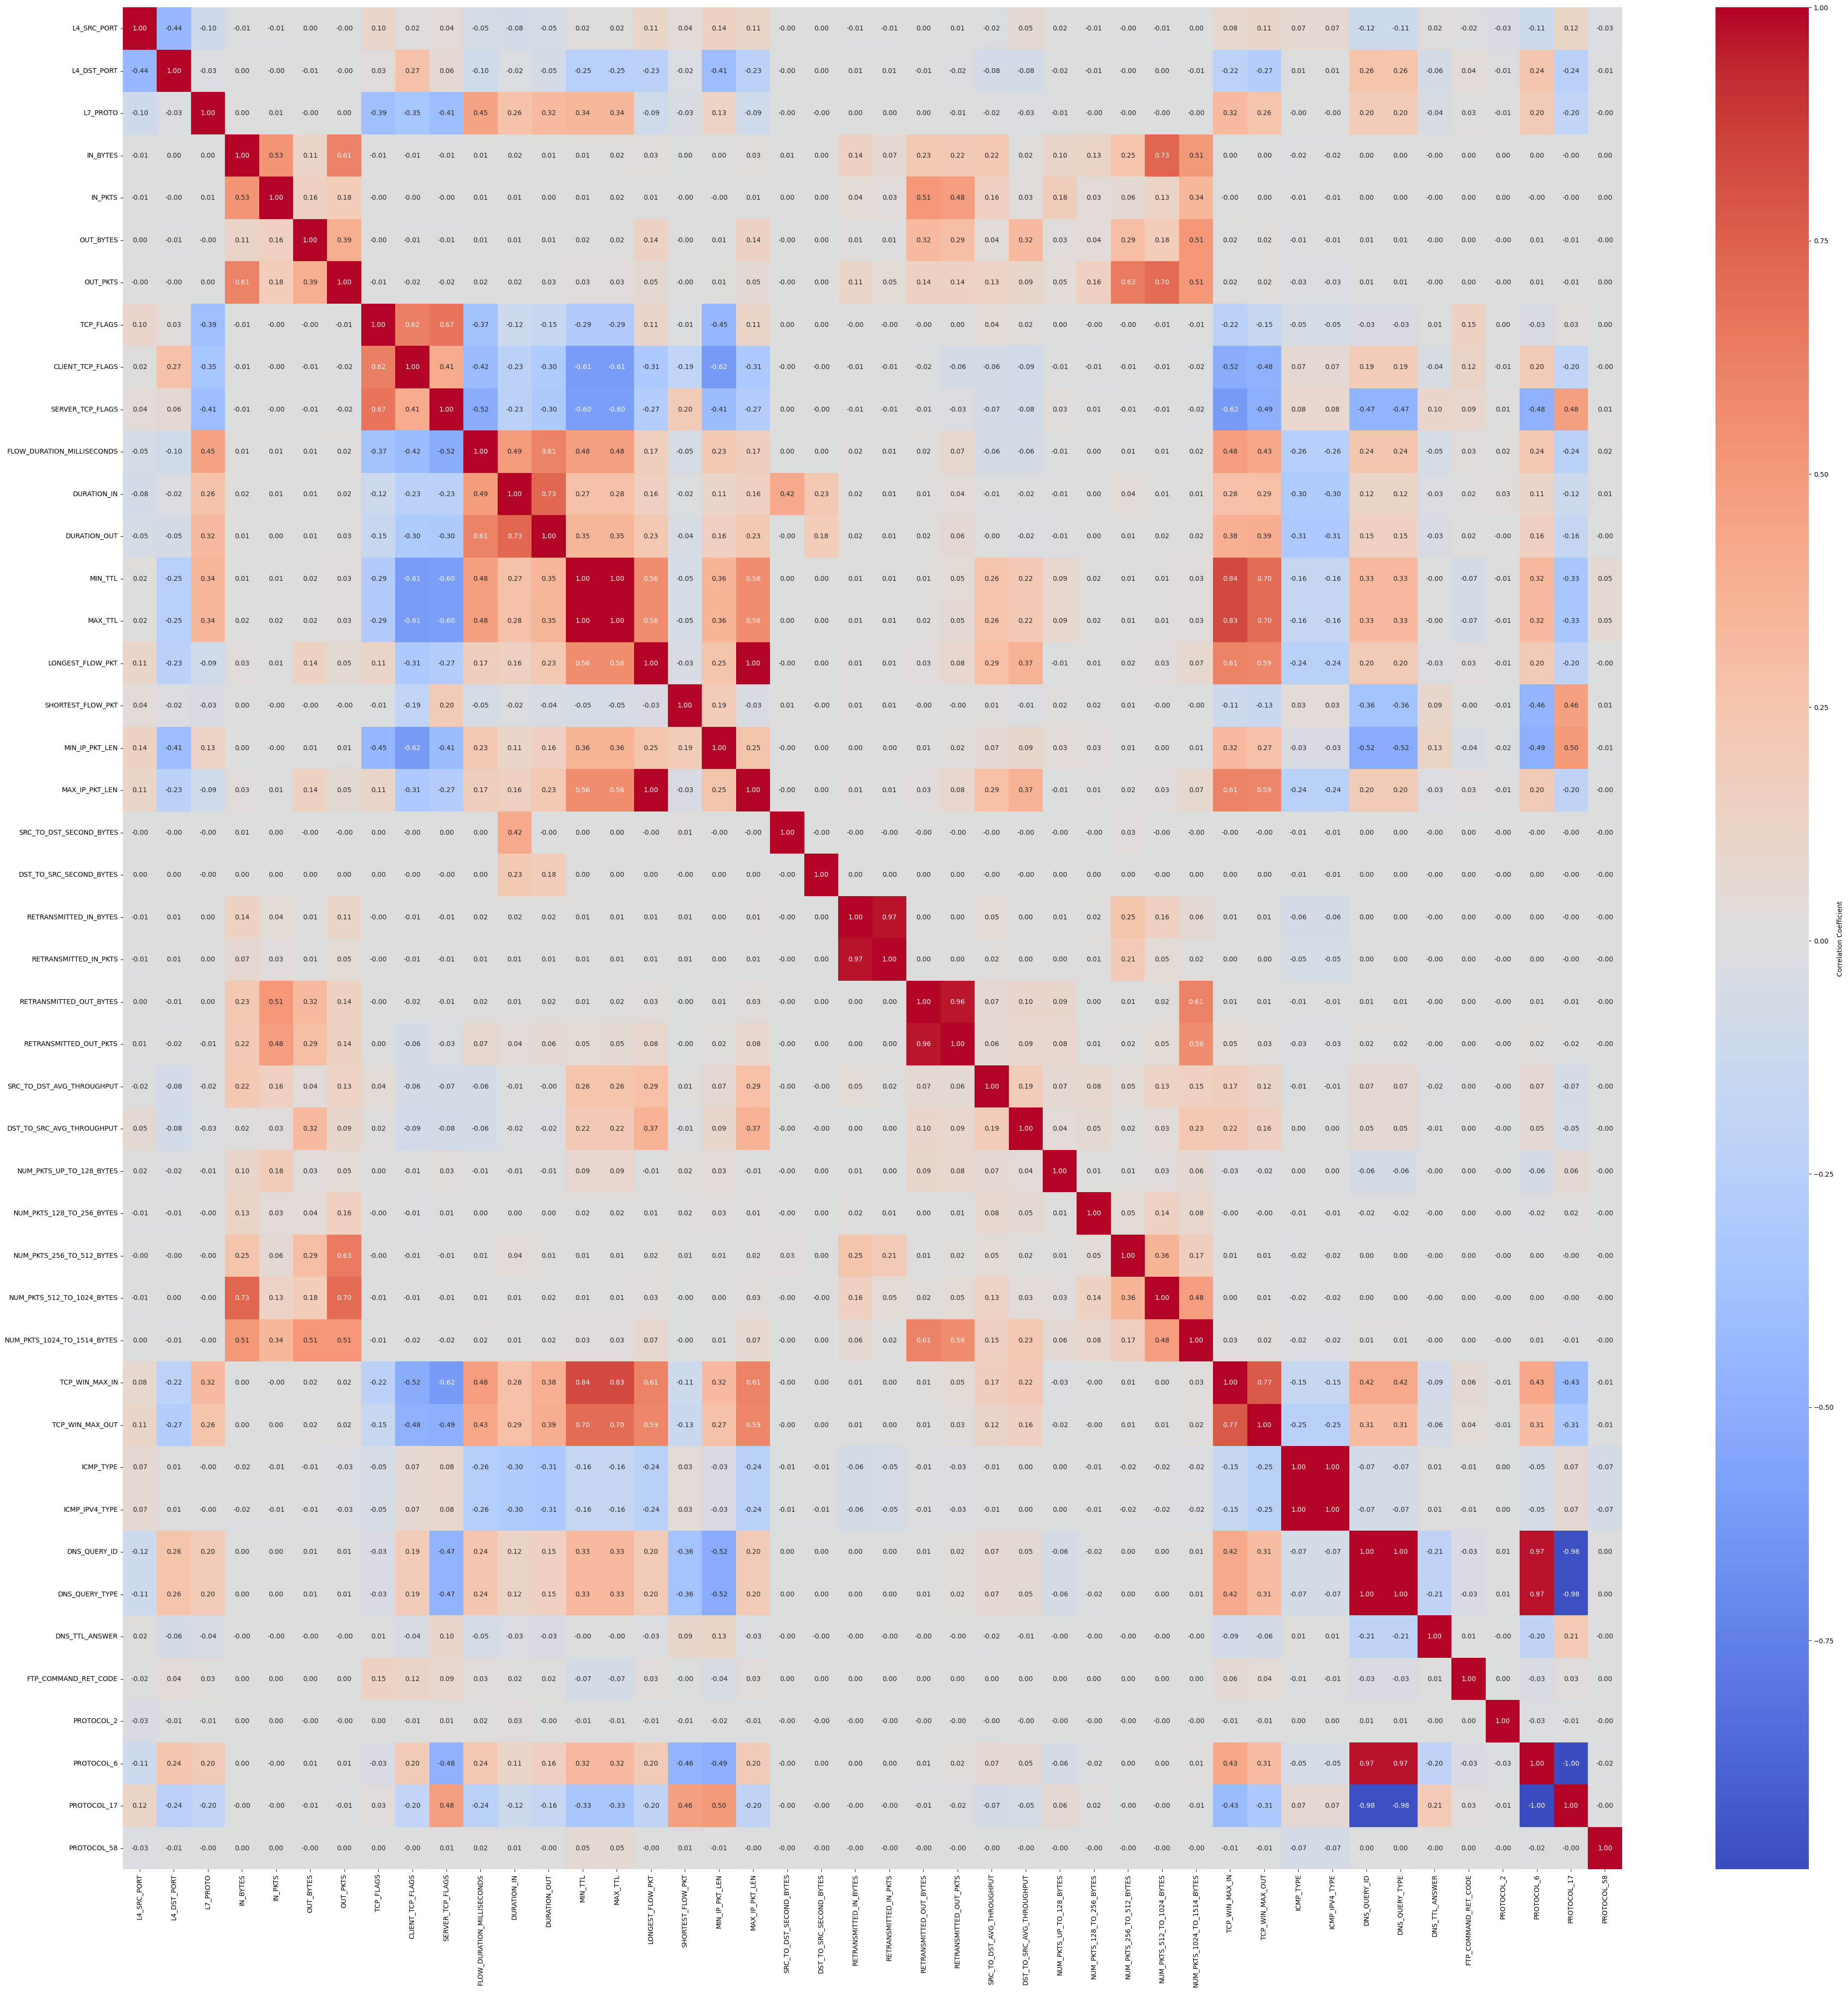

In [72]:
plt.figure(figsize=(50, 50))
sns.heatmap(
    df_fully_encoded.corr(),
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Correlation Coefficient'},
)
plt.show()

Some features have high correlation. The table below shows the most correlated features and their correlation coefficient.

In [73]:
correlation_matrix = df_fully_encoded.corr()

correlation_pairs = correlation_matrix.unstack() # Flatten the matrix into pairs of feature correlations
sorted_correlations = correlation_pairs.abs().sort_values(ascending=False) # Sort the correlations by absolute value
non_self_correlations = sorted_correlations[sorted_correlations < 1] # Exclude self-correlations

print("Top 20 Correlated Features:")
print(non_self_correlations.head(20))


Top 20 Correlated Features:
ICMP_TYPE                ICMP_IPV4_TYPE            1.00
ICMP_IPV4_TYPE           ICMP_TYPE                 1.00
MAX_TTL                  MIN_TTL                   1.00
MIN_TTL                  MAX_TTL                   1.00
DNS_QUERY_TYPE           DNS_QUERY_ID              1.00
DNS_QUERY_ID             DNS_QUERY_TYPE            1.00
PROTOCOL_6               PROTOCOL_17               1.00
PROTOCOL_17              PROTOCOL_6                1.00
                         DNS_QUERY_ID              0.98
DNS_QUERY_ID             PROTOCOL_17               0.98
PROTOCOL_17              DNS_QUERY_TYPE            0.98
DNS_QUERY_TYPE           PROTOCOL_17               0.98
DNS_QUERY_ID             PROTOCOL_6                0.97
PROTOCOL_6               DNS_QUERY_ID              0.97
DNS_QUERY_TYPE           PROTOCOL_6                0.97
PROTOCOL_6               DNS_QUERY_TYPE            0.97
RETRANSMITTED_IN_PKTS    RETRANSMITTED_IN_BYTES    0.97
RETRANSMITTED_IN_BYT

### Handling high correlated features

High correlation between features might affect model's performance. To understand this, we use VIF (Variance Inflation Factor) to detect and quantify multicollinearity in the dataset. This could prevent overfitting, and avoid Numerical Instability.

VIF calculation:

$VIF = \frac{1}{1 - R^{2}}$



In [74]:
numerical_features = features_to_normalize + features_to_standardize + categorial_featues

# Ensure numerical_features only contains valid column names
numerical_features = [feature for feature in numerical_features if feature in df_fully_encoded.columns]

# Check for non-numeric columns
non_numeric_columns = df_fully_encoded[numerical_features].select_dtypes(exclude=['number']).columns
if len(non_numeric_columns) > 0:
    print(f"Non-numeric columns found: {list(non_numeric_columns)}")
    raise ValueError("All features for VIF calculation must be numeric.")

# Create X with only valid numerical features
X = df_fully_encoded[numerical_features].copy()

# Add a constant column for statsmodels
X['constant'] = 1

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Exclude the constant term from results
vif_data = vif_data[vif_data['Feature'] != 'constant']

# Display VIF data
print(vif_data)

                        Feature           VIF
0                      IN_BYTES          4.33
1                     OUT_BYTES          1.78
2                       IN_PKTS          2.27
3                      OUT_PKTS          3.82
4    FLOW_DURATION_MILLISECONDS          2.44
5                   DURATION_IN          3.84
6                  DURATION_OUT          3.47
7       SRC_TO_DST_SECOND_BYTES          1.68
8       DST_TO_SRC_SECOND_BYTES          1.11
9        RETRANSMITTED_IN_BYTES         24.89
10      RETRANSMITTED_OUT_BYTES         20.89
11        RETRANSMITTED_IN_PKTS         24.11
12       RETRANSMITTED_OUT_PKTS         17.93
13    SRC_TO_DST_AVG_THROUGHPUT          1.30
14    DST_TO_SRC_AVG_THROUGHPUT          1.38
15     NUM_PKTS_UP_TO_128_BYTES          1.11
16    NUM_PKTS_128_TO_256_BYTES          1.05
17    NUM_PKTS_256_TO_512_BYTES          2.03
18   NUM_PKTS_512_TO_1024_BYTES          4.41
19  NUM_PKTS_1024_TO_1514_BYTES          3.30
20               DNS_TTL_ANSWER   

In [75]:
del X

Features to drop:


*   ICMP_TYPE
*   MIN_TTL
*   PROTOCOL_17
*   RETRANSMITTED_IN_PKTS
*   RETRANSMITTED_OUT_PKTS
*   LONGEST_FLOW_PKT
*   MAX_IP_PKT_LEN



In [76]:
features_to_drop = ['ICMP_TYPE', 'MIN_TTL', 'PROTOCOL_17', 'RETRANSMITTED_IN_PKTS', 'RETRANSMITTED_OUT_PKTS', 'LONGEST_FLOW_PKT', 'MAX_IP_PKT_LEN']
df_deleted_features = df_fully_encoded.drop(features_to_drop, axis=1)

In [77]:
print(numerical_features)

['IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS', 'FLOW_DURATION_MILLISECONDS', 'DURATION_IN', 'DURATION_OUT', 'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES', 'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_IN_PKTS', 'RETRANSMITTED_OUT_PKTS', 'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT', 'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES', 'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES', 'NUM_PKTS_1024_TO_1514_BYTES', 'DNS_TTL_ANSWER', 'MIN_TTL', 'MAX_TTL', 'LONGEST_FLOW_PKT', 'SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN', 'MAX_IP_PKT_LEN', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT', 'L4_SRC_PORT', 'L4_DST_PORT', 'L7_PROTO', 'TCP_FLAGS', 'CLIENT_TCP_FLAGS', 'SERVER_TCP_FLAGS', 'ICMP_TYPE', 'ICMP_IPV4_TYPE', 'DNS_QUERY_ID', 'DNS_QUERY_TYPE', 'FTP_COMMAND_RET_CODE']


In [78]:
for feature in features_to_drop:
  if feature in numerical_features:
    numerical_features.remove(feature)

X = df_deleted_features[numerical_features].copy()

# Add a constant column for statsmodels
X['constant'] = 1

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Exclude the constant term from results
vif_data = vif_data[vif_data['Feature'] != 'constant']

# Display VIF data
print(vif_data)

                        Feature    VIF
0                      IN_BYTES   4.15
1                     OUT_BYTES   1.73
2                       IN_PKTS   2.23
3                      OUT_PKTS   3.75
4    FLOW_DURATION_MILLISECONDS   2.38
5                   DURATION_IN   3.69
6                  DURATION_OUT   3.36
7       SRC_TO_DST_SECOND_BYTES   1.66
8       DST_TO_SRC_SECOND_BYTES   1.10
9        RETRANSMITTED_IN_BYTES   1.11
10      RETRANSMITTED_OUT_BYTES   2.31
11    SRC_TO_DST_AVG_THROUGHPUT   1.25
12    DST_TO_SRC_AVG_THROUGHPUT   1.29
13     NUM_PKTS_UP_TO_128_BYTES   1.10
14    NUM_PKTS_128_TO_256_BYTES   1.04
15    NUM_PKTS_256_TO_512_BYTES   2.01
16   NUM_PKTS_512_TO_1024_BYTES   3.57
17  NUM_PKTS_1024_TO_1514_BYTES   3.18
18               DNS_TTL_ANSWER   1.08
19                      MAX_TTL   5.21
20            SHORTEST_FLOW_PKT   1.24
21               MIN_IP_PKT_LEN  10.26
22               TCP_WIN_MAX_IN   6.14
23              TCP_WIN_MAX_OUT   3.01
24                  L4_SR

In [79]:
del X

# Classification

## Finding the best classification methods using lazypredict

In [80]:
X_train = lp_fully_encoded.copy()
X_test = lp_test_fully_encoded.copy()
y_train = y_train_lp.copy()
y_test = y_test_lp.copy()

print("X train set size:", X_train.shape)
print("X test set size:", X_test.shape)

print("Y train set size:", y_train.shape)
print("Y test set size:", y_test.shape)

X train set size: (735609, 44)
X test set size: (315261, 44)
Y train set size: (735609,)
Y test set size: (315261,)


In [81]:
X_train = X_train.drop(features_to_drop, axis=1)
X_test = X_test.drop(features_to_drop, axis=1)

In [82]:
print("X train set size:", X_train.shape)
print("X test set size:", X_test.shape)

X train set size: (735609, 37)
X test set size: (315261, 37)


In [ ]:
lazy_classifier = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = lazy_classifier.fit(X_train, X_test, y_train, y_test)

 10%|▉         | 3/31 [04:43<35:43, 76.55s/it]   

In [ ]:
print(models)

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
RandomForestClassifier             0.93               0.81    None      0.93   
BaggingClassifier                  0.70               0.50    None      0.72   
DecisionTreeClassifier             0.66               0.49    None      0.67   
BernoulliNB                        0.30               0.44    None      0.28   
ExtraTreesClassifier               0.56               0.40    None      0.52   
NearestCentroid                    0.20               0.34    None      0.16   
LogisticRegression                 0.23               0.29    None      0.17   
AdaBoostClassifier                 0.42               0.28    None      0.28   
LinearDiscriminantAnalysis         0.09               0.23    None      0.04   
SGDClassifier                      0.31               0.21    None      0.19   
PassiveAggressiveClassifier        0.10 

Lazypredict gives us 4 metrics for each classification model.
Accuracy is calculated based on the formula below:
$$Accuracy = \frac{True Positive (TP) + True Negatives (TN)}{Total Instances}$$
When the dataset is balanced (the number of the samples in each class is nearly equal) using accuracy is recommended.

So we should calculate the balanced accuracy. This metric is the average of recall calculated for each class:

$$Balanced Accuracy = \frac{1}{C} \sum_{i=1}^{C} Recall_{i}$$

in this formula, $C$ is the total number of classes, and $Recall_{i} = \frac{True Positives_{i}}{True Positives_{i} + False Negatives_{i}}$.

A model with low balanced accuracy could overfit to the majority class and a model with higher balanced accuracy means it performs better across all classes.

The metric 'ROC AUC' is useful only for binary classification. So this metric doesn't have any use to us in this project.

The next metric is 'F1 Score' which is the harmonic mean of Precision and Recall.
$$F1 Score = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$
In this formula, Precision and Recall (Sensitivity) are defined as:
$$Precision \frac{True Positives}{True Positives + False Positives}$$
$$Recall = \frac{True Positives}{True Positives + False Negatives}$$

F1 Score has better performance on imbalanced models. When the dataset is balanced and misclassification costs are equal, accuracy and F1 score will usually provide similar results. But on imbalanced datasets, accuracy might be high while F1 score is low, which indicates that the model is biased towards the majority class. In this scenario, F1 score ia a better indicator of model's performance.

We choose the three models to run them on the sample data frame;


1.   RandomForestClassifier
2.   KNeighborsClassifier
3.   LinearDiscriminantAnalysis



## Splitting the main dataframe

In [ ]:
X_train = df_fully_encoded.copy()
X_test = df_test_fully_encoded.copy()
y_train = y_train_main.copy()
y_test = y_test_main.copy()

X_train = X_train.drop(features_to_drop, axis=1)
X_test = X_test.drop(features_to_drop, axis=1)

print("X train set size:", X_train.shape)
print("X test set size:", X_test.shape)

print("Y train set size:", y_train.shape)
print("Y test set size:", y_test.shape)

X train set size: (91951, 37)
X test set size: (39408, 37)
Y train set size: (91951,)
Y test set size: (39408,)


## Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(
    criterion="gini",       # Options: "gini" or "entropy" (default: "gini")
    max_depth=None,         # Max depth of the tree (default: unlimited depth)
    random_state=42         # Ensure reproducibility
)

dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
y_pred = dt_clf.predict(X_test)

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6319782785221275

Classification Report:
               precision    recall  f1-score   support

      Benign       0.81      0.73      0.76     10744
    backdoor       1.00      0.43      0.60        44
        ddos       0.80      0.88      0.84      5388
         dos       1.00      0.01      0.01      1937
   injection       0.11      0.51      0.18      1966
        mitm       0.00      0.00      0.00        23
    password       0.47      0.22      0.30      2886
  ransomware       0.21      0.80      0.33        10
    scanning       0.83      0.92      0.87      9086
         xss       0.77      0.33      0.46      7324

    accuracy                           0.63     39408
   macro avg       0.60      0.48      0.44     39408
weighted avg       0.75      0.63      0.64     39408



## Bagging Classifier

In [ ]:
from sklearn.ensemble import BaggingClassifier
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(),  # Base model
    n_estimators=50,                          # Number of base models
    max_samples=0.8,                          # Fraction of training data to sample
    max_features=0.8,                         # Fraction of features to sample
    random_state=42                           # Ensure reproducibility
)
bagging_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_features=0.8,
                  max_samples=0.8, n_estimators=50, random_state=42)

In [ ]:
y_pred = bagging_clf.predict(X_test)

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7433008526187577

Classification Report:
               precision    recall  f1-score   support

      Benign       0.94      0.88      0.91     10744
    backdoor       1.00      0.43      0.60        44
        ddos       0.96      0.93      0.95      5388
         dos       0.98      0.07      0.12      1937
   injection       0.16      0.82      0.27      1966
        mitm       0.00      0.00      0.00        23
    password       0.75      0.76      0.76      2886
  ransomware       0.89      0.80      0.84        10
    scanning       0.99      0.95      0.97      9086
         xss       0.91      0.30      0.45      7324

    accuracy                           0.74     39408
   macro avg       0.76      0.59      0.59     39408
weighted avg       0.90      0.74      0.76     39408



## Random Forest Classifier

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = rf_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7923010556232237

Classification Report:
               precision    recall  f1-score   support

      Benign       0.64      0.98      0.78     10744
    backdoor       1.00      1.00      1.00        44
        ddos       0.88      0.94      0.91      5388
         dos       0.90      0.61      0.73      1937
   injection       0.71      0.77      0.74      1966
        mitm       1.00      0.43      0.61        23
    password       0.91      0.84      0.87      2886
  ransomware       0.89      0.80      0.84        10
    scanning       0.98      0.44      0.60      9086
         xss       0.92      0.88      0.90      7324

    accuracy                           0.79     39408
   macro avg       0.88      0.77      0.80     39408
weighted avg       0.84      0.79      0.78     39408

